In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append('../')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
PATH = f'../data/connectomes/'
DATASET = ''

selected_networks = [
    'c.elegans_neural.male_1.graphml',
    'mouse_brain_1.graphml',
    'mouse_visual.cortex_2.graphml', 
    'p.pacificus_neural.synaptic_2.graphml',
    'rhesus_brain_2.graphml'
]

# Read graphs for selected networks
graphs = []
for network in selected_networks:
    try:
        g = nx.read_graphml(PATH + network)
        graphs.append(g)
    except Exception as e:
        print(f"Error reading {network}: {e}")

# Sort networks and graphs by size
if len(graphs) > 0:
    graph_sizes = [(f, len(g.nodes())) for f, g in zip(selected_networks, graphs)]
    graph_sizes.sort(key=lambda x: x[1])
    selected_networks = [f for f, _ in graph_sizes]
    graphs = [g for _, g in sorted(zip(graph_sizes, graphs), key=lambda x: x[0][1])]


In [4]:
# Load the results
df_results = pd.read_csv('tabela_caracteristicas.csv')
df_results.head(10)

,Unnamed: 0,network,estimated_sigma,adjusted_hops,vertices,edges,degree_centrality,betweenness_centrality,closeness_centrality,clustering_coeff,density,transitivity,average_Degree,maximum_Degree
0,0,rhesus_brain_2,-5.395738,0,91,294,0.071795,0.016403,0.384434,0.162076,0.071795,0.130680,6.461538,27
1,0,rattus.norvegicus_brain_1,-1.648310,2,503,9172,0.072648,0.001982,0.502056,0.071255,0.072648,0.071328,36.469185,54
2,0,p.pacificus_neural.synaptic_1,-3.125950,0,54,427,0.298393,0.013587,0.587213,0.308822,0.298393,0.301250,15.814815,25
3,0,rhesus_brain_1,-6.183950,2,242,1923,0.065944,0.005250,0.443717,0.062656,0.065944,0.062410,15.892562,27
4,0,rattus.norvegicus_brain_3,-3.870713,1,496,8398,0.068410,0.002071,0.494658,0.068315,0.068410,0.068104,33.862903,56
5,0,rattus.norvegicus_brain_2,-3.019719,2,503,8822,0.069876,0.002015,0.497879,0.069074,0.069876,0.068925,35.077535,52
6,0,p.pacificus_neural.synaptic_2,-2.921838,0,50,520,0.424490,0.011990,0.636553,0.447899,0.424490,0.441990,20.800000,29
7,0,mouse_brain_1,-1.755647,1,213,7984,0.353619,0.003063,0.607674,0.355194,0.353619,0.355112,74.967136,95
8,0,c.elegans.herm_pharynx_1,-4.338917,2,279,3555,0.091669,0.003599,0.501156,0.090847,0.091669,0.091318,25.483871,38
9,0,mouse_visual.cortex_2,-6.098704,1,195,266,0.014063,0.010448,0.175089,0.016090,0.014063,0.027248,2.728205,13


In [5]:
def get_logit_graph(real_graph, d, n_iteration, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
   """
   Estimates parameters, generates a graph using the Logit Graph model,
   and calculates GIC, allowing for different convergence criteria.

   Args:
       real_graph (nx.Graph or np.ndarray): The target graph.
       d (int): Parameter for the Logit model (number of neighbors).
       n_iteration (int): Maximum number of iterations for graph generation.
       warm_up (int): Number of initial iterations to discard.
       patience (int): Number of iterations to wait for improvement before stopping.
       dist_type (str): Distance type for GIC ('KL', 'L1', 'L2').
       convergence_criteria (str): Criterion for stopping ('spectrum' or 'spectrum_and_edges').

   Returns:
       tuple: Contains the best generated graph, sigma, GIC values,
              spectrum differences, edge differences, best iteration index, and all graphs.
   """
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)

   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   # Using default L1 regularization as before, adjust if needed
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "patience": patience,
      "edge_delta": edge_delta,
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

   print(f"Running generation with convergence criterion: {edge_delta}")
   
   graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )


   print(f"Finish generation with convergence criterion: {edge_delta}")
   # Calculate edge differences
   real_edges = np.sum(real_graph) / 2
   edge_diffs = [abs(np.sum(g) / 2 - real_edges) for g in graphs]

   # Use the best graph found based on the selected criteria/iteration
   # best_graph = graphs[best_iteration]

   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph_arr)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type
   ).calculate_gic()

   return best_graph_arr, sigma, [gic_value], spectrum_diffs, edge_diffs, best_iteration, graphs


In [6]:
# Updated fit_logit_graphs_to_dataset function to properly return sigma and d values
def fit_logit_graphs_to_dataset_improved(graphs, n_graphs=5, sim_params=None):
    """
    Fit logit graph models to the selected graphs and extract network features.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n_graphs : int
        Number of graphs to process
    sim_params : dict
        Simulation parameters for logit graph fitting
        
    Returns:
    --------
    results : list
        List of dictionaries containing results for each network
    """
    results = []
    n_graphs = min(n_graphs, len(graphs))
    
    for i in range(n_graphs):
        
        original_graph = graphs[i]
        adj_matrix = nx.to_numpy_array(original_graph)
        n_nodes = original_graph.number_of_nodes()
        n_edges = original_graph.number_of_edges()
        
        print(f"Original graph - Nodes: {n_nodes}, Edges: {n_edges}")
        
        # Test different d values and find the best one based on GIC
        best_gic_value = float('inf')
        best_d = 0
        best_sigma = None
        best_fitted_graph = None
        
        for d in range(sim_params["d_range"]): 
            print(f"\n{'='*20} Processing Graph {i+1}/{n_graphs} with d={d} {'='*20}")
            try:
                logit_results = get_logit_graph(
                    real_graph=adj_matrix.copy(),
                    d=d,
                    n_iteration=sim_params["n_iteration"],
                    patience=sim_params["patience"],
                    dist_type=sim_params["dist_type"],
                    edge_delta=sim_params["edge_delta"],
                    min_gic_threshold=sim_params["min_gic_threshold"],
                    verbose=sim_params["verbose"],
                )
                
                fitted_adj_matrix, sigma, gic_values, spectrum_diffs, edge_diffs, best_iteration, all_graphs = logit_results
                gic_value = gic_values[0]
                
                print(f"  d={d}: sigma={sigma:.4f}, GIC={gic_value:.4f}")
                
                if gic_value < best_gic_value:
                    best_gic_value = gic_value
                    best_d = d
                    best_sigma = sigma
                    best_fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
                    
            except Exception as e:
                print(f"  Error with d={d}: {str(e)}")
                continue
        
        if best_fitted_graph is None:
            print(f"Failed to fit any model for graph {i+1}")
            continue
            
        result = {
            'network': graphs[i],
            'sigma': best_sigma,
            'd_parameter': best_d,
            'n_vertices': n_nodes,
            'n_edges': n_edges,
            'gic_value': best_gic_value,
            'fitted_graph': best_fitted_graph,
        }
        
        results.append(result)
        
    return results


In [7]:
# Match selected networks with df_results and extract parameters
def get_network_params_from_results(selected_networks, df_results):
    """
    Match selected networks with df_results and extract sigma and d parameters
    """
    network_params = {}
    
    for network_file in selected_networks:
        # Remove .graphml extension and try to match with df_results
        network_name = network_file.replace('.graphml', '')
        
        # Try exact match first
        matches = df_results[df_results['network'] == network_name]
        
        # If no exact match, try partial matching
        if matches.empty:
            matches = df_results[df_results['network'].str.contains(network_name.split('_')[0], na=False)]
        
        # If still no match, try more flexible matching
        if matches.empty:
            for _, row in df_results.iterrows():
                if any(part in row['network'] for part in network_name.split('_')[:2]):
                    matches = df_results[df_results['network'] == row['network']]
                    break
        
        if not matches.empty:
            # Take the first match if multiple
            match = matches.iloc[0]
            network_params[network_file] = {
                'sigma': match['estimated_sigma'],
                'd': match['adjusted_hops'],
                'matched_name': match['network']
            }
            print(f"Matched {network_file} -> {match['network']}")
            print(f"  sigma: {match['estimated_sigma']:.4f}, d: {match['adjusted_hops']}")
        else:
            print(f"No match found for {network_file}")
    
    return network_params

# Get parameters for selected networks
network_params = get_network_params_from_results(selected_networks, df_results)
print(f"\nFound parameters for {len(network_params)} networks")


Matched p.pacificus_neural.synaptic_2.graphml -> p.pacificus_neural.synaptic_2
  sigma: -2.9218, d: 0
Matched rhesus_brain_2.graphml -> rhesus_brain_2
  sigma: -5.3957, d: 0
Matched mouse_visual.cortex_2.graphml -> mouse_visual.cortex_2
  sigma: -6.0987, d: 1
Matched mouse_brain_1.graphml -> mouse_brain_1
  sigma: -1.7556, d: 1
Matched c.elegans_neural.male_1.graphml -> c.elegans_neural.male_1
  sigma: -4.5287, d: 0

Found parameters for 5 networks


In [ ]:
# Generate LG graphs using specific sigma and d values
def generate_lg_graphs_with_params(graphs, selected_networks, network_params, sim_params):
    """
    Generate logit graphs using specific sigma and d parameters from df_results
    """
    results = []
    
    for i, (graph, network_file) in enumerate(zip(graphs, selected_networks)):
        if network_file not in network_params:
            print(f"Skipping {network_file} - no parameters found")
            continue
            
        params = network_params[network_file]
        sigma = params['sigma']
        d = params['d']
        
        print(f"\n{'='*50}")
        print(f"Processing {network_file}")
        print(f"Using sigma={sigma:.4f}, d={d}")
        print(f"Original graph - Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")
        
        try:
            adj_matrix = nx.to_numpy_array(graph)
            
            # Generate LG graph with specific parameters
            logit_results = get_logit_graph(
                real_graph=adj_matrix.copy(),
                d=d,
                n_iteration=sim_params["n_iteration"],
                patience=sim_params["patience"],
                dist_type=sim_params["dist_type"],
                edge_delta=sim_params["edge_delta"],
                min_gic_threshold=sim_params["min_gic_threshold"],
                verbose=sim_params["verbose"],
            )
            
            fitted_adj_matrix, fitted_sigma, gic_values, spectrum_diffs, edge_diffs, best_iteration, all_graphs = logit_results
            fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
            
            result = {
                'network_file': network_file,
                'matched_name': params['matched_name'],
                'original_graph': graph,
                'fitted_graph': fitted_graph,
                'target_sigma': sigma,
                'fitted_sigma': fitted_sigma,
                'target_d': d,
                'gic_value': gic_values[0],
                'best_iteration': best_iteration
            }
            
            results.append(result)
            
            print(f"Success! Generated graph with {fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges")
            print(f"Target sigma: {sigma:.4f}, Fitted sigma: {fitted_sigma:.4f}")
            print(f"GIC: {gic_values[0]:.4f}, Best iteration: {best_iteration}")
            
        except Exception as e:
            print(f"Error processing {network_file}: {str(e)}")
            continue
    
    return results
# # Set up simulation parameters (reduced for faster execution)
# sim_params = {
#     "n_iteration": 100,  # Reduced for faster execution
#     "patience": 5,
#     "edge_delta": 50,
#     "dist_type": 'KL',
#     "min_gic_threshold": 2,
#     "verbose": True,
# }

# original
sim_params = {
    "n_iteration": 20_000,
    "d_range": 3,
    "patience": 1000,
    "edge_delta": 50,
    "dist_type": 'KL',
    "min_gic_threshold": 2,
    "verbose": True,
}

# Generate LG graphs
print("Starting LG graph generation...")
lg_results = generate_lg_graphs_with_params(graphs, selected_networks, network_params, sim_params)


Starting LG graph generation...

Processing p.pacificus_neural.synaptic_2.graphml
Using sigma=-2.9218, d=0
Original graph - Nodes: 272, Edges: 4451
Running generation with convergence criterion: 50


Optimizing Graph:   0%|          | 3/20000 [00:00<09:13, 36.14it/s, GIC=23.0151, Spectrum Diff=446.5356, Patience=0/1000, Edges=0.0/1981.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 2)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1981.0)


Optimizing Graph:   1%|▏         | 278/20000 [00:06<06:50, 48.00it/s, GIC=23.0151, Spectrum Diff=446.5356, Patience=0/1000, Edges=0.0/1981.0]

In [9]:
# Visualization functions for comprehensive comparison
def plot_all_graphs_comparison(lg_results, figsize=(20, 12)):
    """
    Create a comprehensive visualization showing all graphs in subplots
    """
    n_networks = len(lg_results)
    if n_networks == 0:
        print("No results to plot")
        return
    
    # Create subplot grid (2 columns: original and LG generated)
    fig, axes = plt.subplots(n_networks, 2, figsize=figsize)
    
    # Handle case where there's only one network
    if n_networks == 1:
        axes = axes.reshape(1, -1)
    
    for i, result in enumerate(lg_results):
        original_graph = result['original_graph']
        fitted_graph = result['fitted_graph']
        network_name = result['network_file'].replace('.graphml', '')
        
        # Original graph
        pos1 = nx.spring_layout(original_graph, seed=42, k=1, iterations=50)
        nx.draw_networkx(original_graph, pos=pos1, ax=axes[i, 0], 
                        node_color='lightblue', node_size=30, 
                        with_labels=False, edge_color='gray', alpha=0.7, width=0.5)
        axes[i, 0].set_title(f'{network_name} (Original)\nNodes: {original_graph.number_of_nodes()}, Edges: {original_graph.number_of_edges()}', 
                            fontsize=10)
        axes[i, 0].axis('off')
        
        # LG Generated graph
        pos2 = nx.spring_layout(fitted_graph, seed=42, k=1, iterations=50)
        nx.draw_networkx(fitted_graph, pos=pos2, ax=axes[i, 1],
                        node_color='lightcoral', node_size=30,
                        with_labels=False, edge_color='gray', alpha=0.7, width=0.5)
        axes[i, 1].set_title(f'{network_name} (LG Generated)\nNodes: {fitted_graph.number_of_nodes()}, Edges: {fitted_graph.number_of_edges()}\nσ={result["fitted_sigma"]:.3f}, d={result["target_d"]}, GIC={result["gic_value"]:.3f}', 
                            fontsize=10)
        axes[i, 1].axis('off')
    
    plt.suptitle('Graph Structure Comparison: Original vs LG Generated', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_all_degree_distributions_comparison(lg_results, figsize=(20, 12)):
    """
    Create a comprehensive visualization showing all degree distributions in subplots
    """
    n_networks = len(lg_results)
    if n_networks == 0:
        print("No results to plot")
        return
    
    # Create subplot grid (2 columns: original and LG generated)
    fig, axes = plt.subplots(n_networks, 2, figsize=figsize)
    
    # Handle case where there's only one network
    if n_networks == 1:
        axes = axes.reshape(1, -1)
    
    for i, result in enumerate(lg_results):
        original_graph = result['original_graph']
        fitted_graph = result['fitted_graph']
        network_name = result['network_file'].replace('.graphml', '')
        
        # Original graph degree distribution
        degrees_orig = [d for n, d in original_graph.degree()]
        max_degree_orig = max(degrees_orig) if degrees_orig else 1
        bins_orig = min(20, max_degree_orig + 1)
        
        axes[i, 0].hist(degrees_orig, bins=bins_orig, alpha=0.7, color='lightblue', edgecolor='black')
        axes[i, 0].set_title(f'{network_name} (Original)\nDegree Distribution', fontsize=10)
        axes[i, 0].set_xlabel('Degree', fontsize=9)
        axes[i, 0].set_ylabel('Frequency', fontsize=9)
        axes[i, 0].tick_params(axis='both', which='major', labelsize=8)
        
        # LG Generated graph degree distribution
        degrees_fitted = [d for n, d in fitted_graph.degree()]
        max_degree_fitted = max(degrees_fitted) if degrees_fitted else 1
        bins_fitted = min(20, max_degree_fitted + 1)
        
        axes[i, 1].hist(degrees_fitted, bins=bins_fitted, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[i, 1].set_title(f'{network_name} (LG Generated)\nDegree Distribution', fontsize=10)
        axes[i, 1].set_xlabel('Degree', fontsize=9)
        axes[i, 1].set_ylabel('Frequency', fontsize=9)
        axes[i, 1].tick_params(axis='both', which='major', labelsize=8)
    
    plt.suptitle('Degree Distribution Comparison: Original vs LG Generated', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_graph_metrics_comparison(lg_results):
    """
    Create a comparison table of graph metrics
    """
    metrics_data = []
    
    for result in lg_results:
        orig_graph = result['original_graph']
        fitted_graph = result['fitted_graph']
        
        # Calculate metrics
        orig_metrics = {
            'nodes': orig_graph.number_of_nodes(),
            'edges': orig_graph.number_of_edges(),
            'density': nx.density(orig_graph),
            'avg_degree': sum(dict(orig_graph.degree()).values()) / orig_graph.number_of_nodes()
        }
        
        fitted_metrics = {
            'nodes': fitted_graph.number_of_nodes(),
            'edges': fitted_graph.number_of_edges(),
            'density': nx.density(fitted_graph),
            'avg_degree': sum(dict(fitted_graph.degree()).values()) / fitted_graph.number_of_nodes()
        }
        
        metrics_data.append({
            'Network': result['network_file'].replace('.graphml', ''),
            'Type': 'Original',
            **orig_metrics
        })
        
        metrics_data.append({
            'Network': result['network_file'].replace('.graphml', ''),
            'Type': 'LG Generated',
            **fitted_metrics
        })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    metrics_to_plot = ['edges', 'density', 'avg_degree']
    
    for i, metric in enumerate(metrics_to_plot):
        if i < len(axes):
            pivot_df = df_metrics.pivot(index='Network', columns='Type', values=metric)
            pivot_df.plot(kind='bar', ax=axes[i], alpha=0.8)
            axes[i].set_title(f'{metric.replace("_", " ").title()}')
            axes[i].set_xlabel('Network')
            axes[i].set_ylabel(metric.replace("_", " ").title())
            axes[i].legend()
            axes[i].tick_params(axis='x', rotation=45)
    
    # Remove empty subplot
    if len(metrics_to_plot) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
    return df_metrics


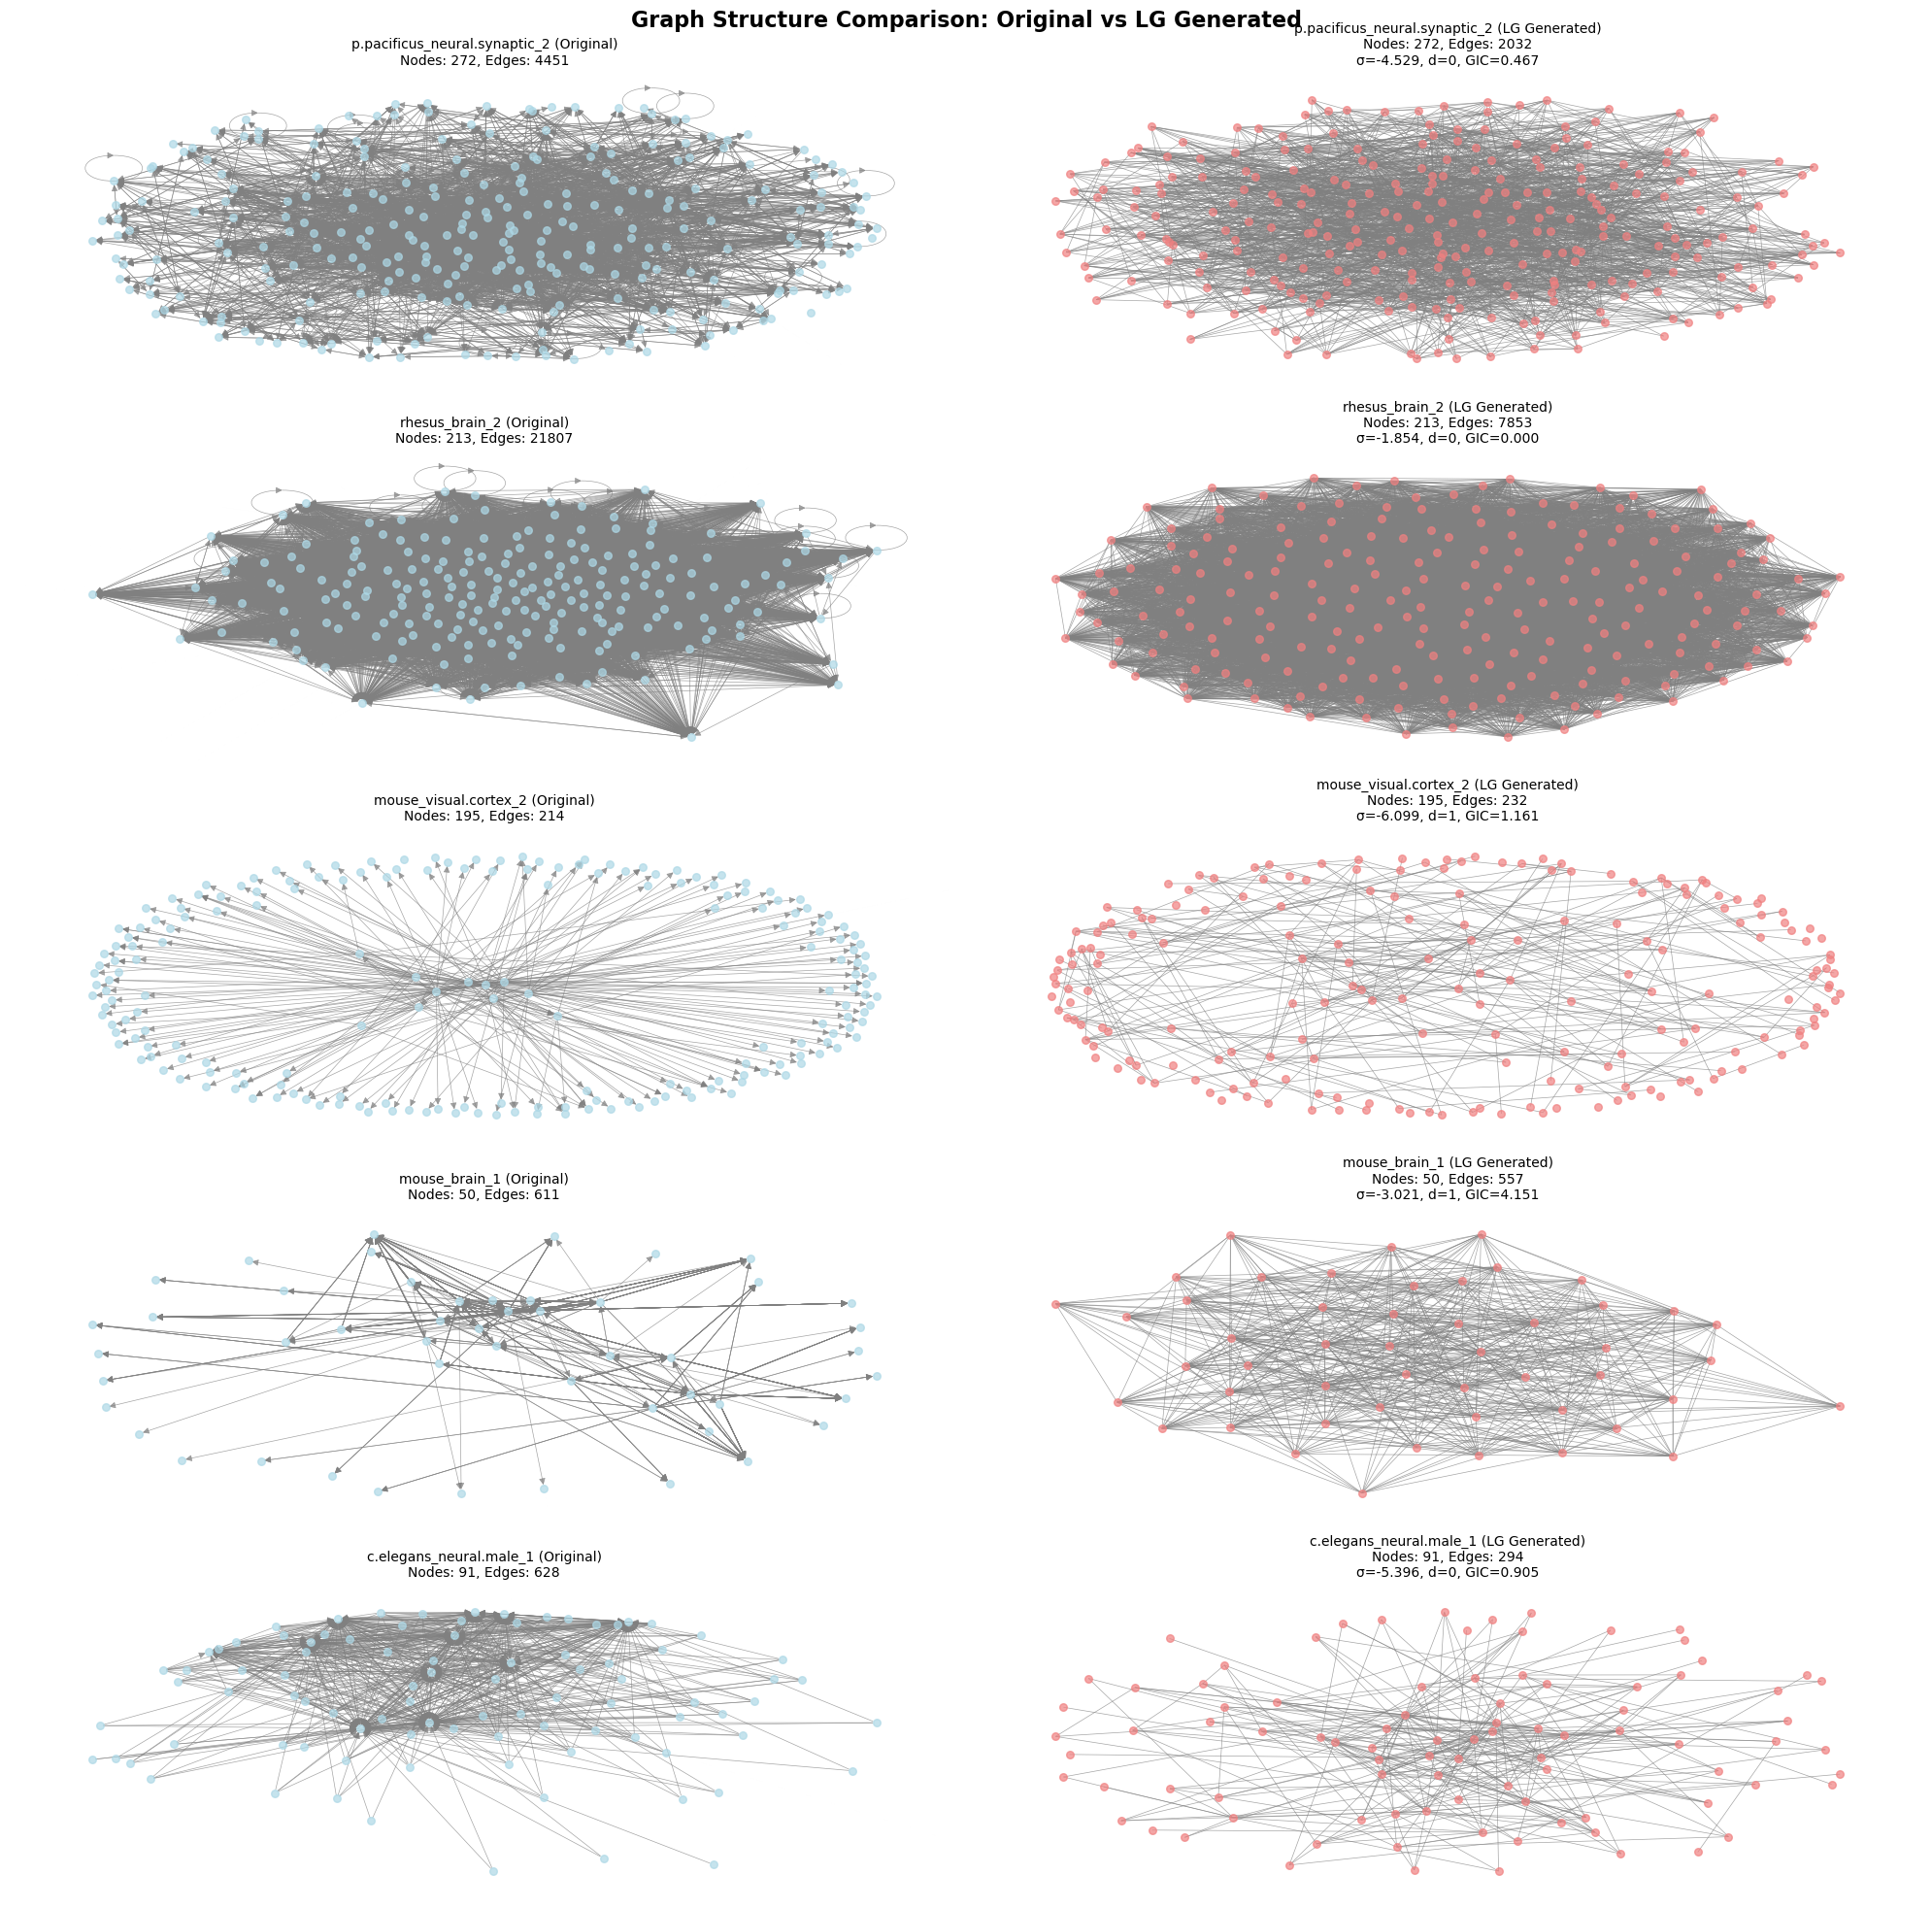

In [10]:
plot_all_graphs_comparison(lg_results, figsize=(20, 20))
 

Creating visualizations for 5 networks...
Network 1: p.pacificus_neural.synaptic_2
  Target σ=-2.9218, Fitted σ=-4.5287, d=0
  GIC: 0.4673, Best iteration: 6394
Network 2: rhesus_brain_2
  Target σ=-5.3957, Fitted σ=-1.8538, d=0
  GIC: 0.0000, Best iteration: 9999
Network 3: mouse_visual.cortex_2
  Target σ=-6.0987, Fitted σ=-6.0987, d=1
  GIC: 1.1610, Best iteration: 2077
Network 4: mouse_brain_1
  Target σ=-1.7556, Fitted σ=-3.0211, d=1
  GIC: 4.1507, Best iteration: 832
Network 5: c.elegans_neural.male_1
  Target σ=-4.5287, Fitted σ=-5.3957, d=0
  GIC: 0.9050, Best iteration: 2794

------------------------------------------------------------
2. All Degree Distribution Comparisons


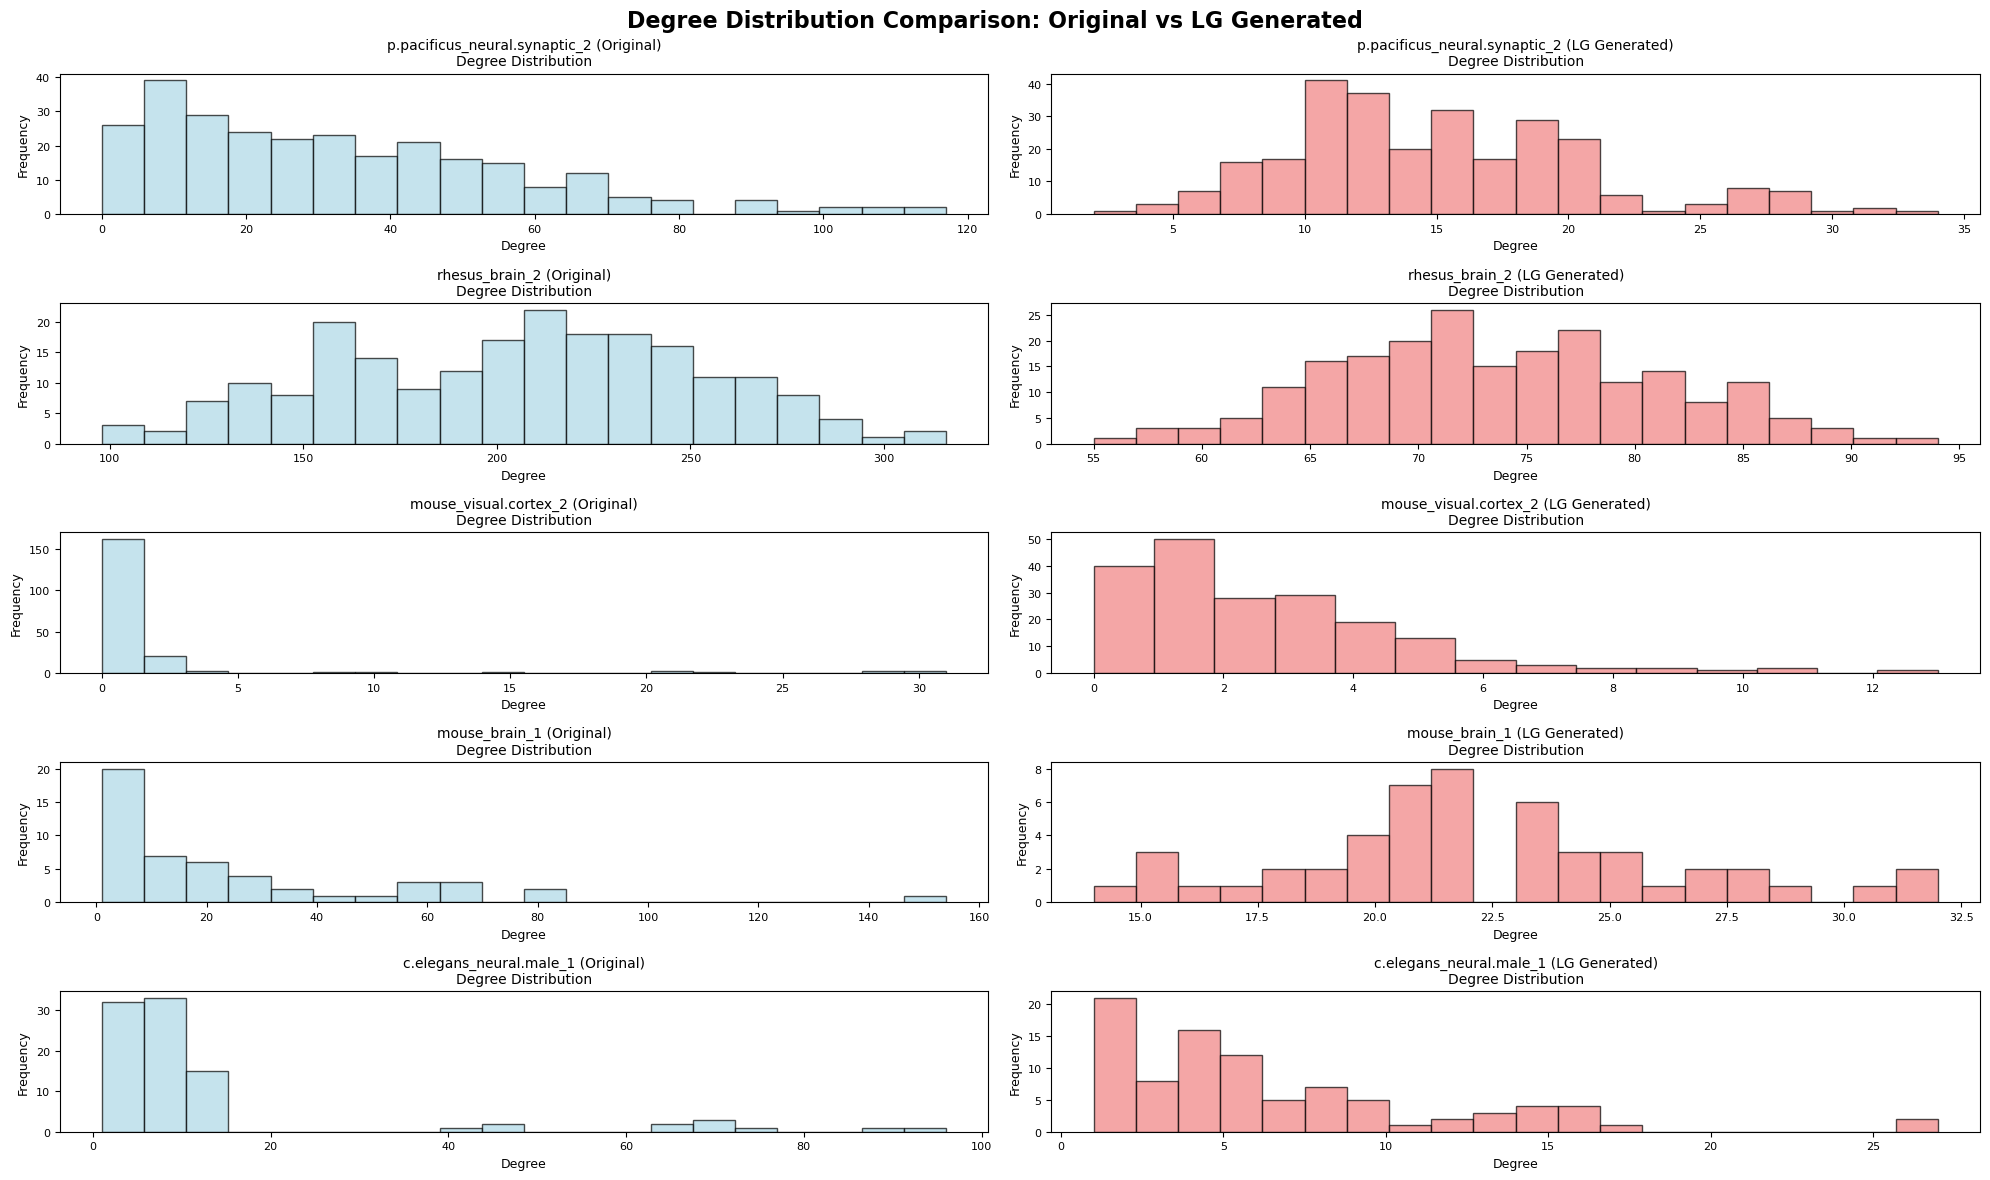


------------------------------------------------------------
3. Overall Metrics Comparison


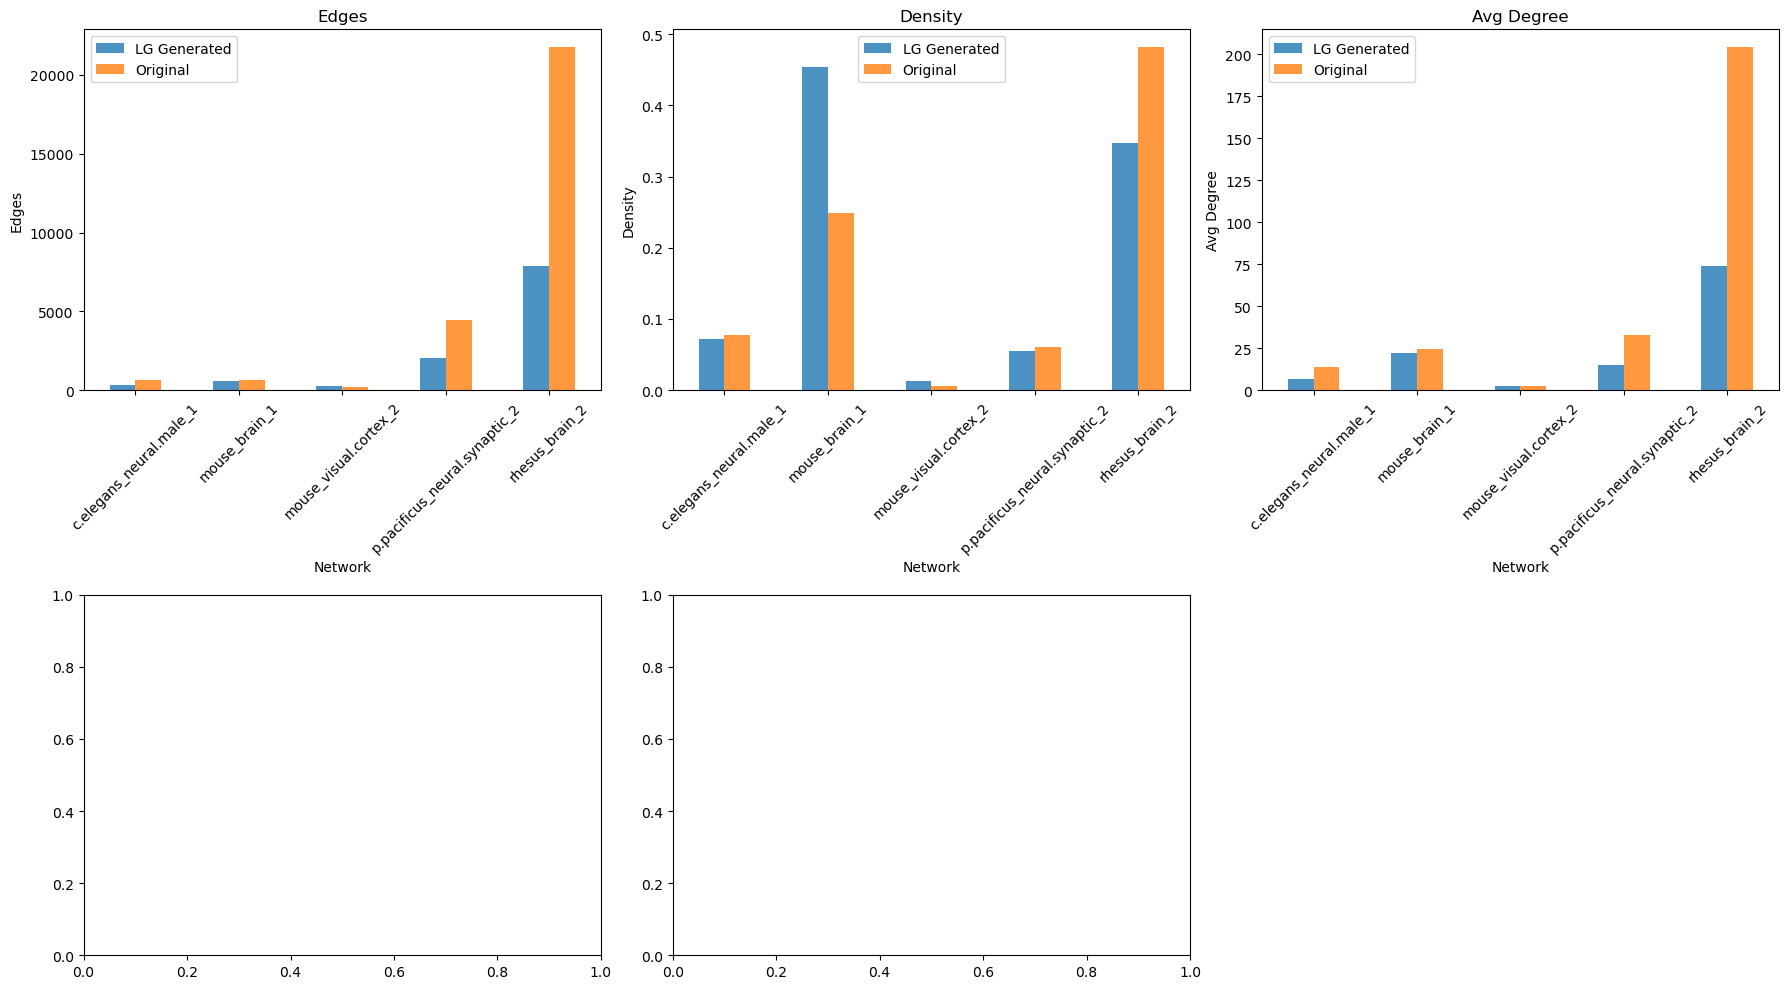


------------------------------------------------------------
4. Summary Table:


,Network,Matched_Name,Original_Nodes,Original_Edges,LG_Edges,Edge_Diff,Target_Sigma,Fitted_Sigma,Target_d,GIC,Best_Iteration
0,p.pacificus_neural.synaptic_2,p.pacificus_neural.synaptic_2,272,4451,2032,2419,-2.921838,-4.528701,0,0.467347,6394
1,rhesus_brain_2,rhesus_brain_2,213,21807,7853,13954,-5.395738,-1.853848,0,0.000000,9999
2,mouse_visual.cortex_2,mouse_visual.cortex_2,195,214,232,18,-6.098704,-6.098704,1,1.160985,2077
3,mouse_brain_1,mouse_brain_1,50,611,557,54,-1.755647,-3.021145,1,4.150696,832
4,c.elegans_neural.male_1,c.elegans_neural.male_1,91,628,294,334,-4.528701,-5.395738,0,0.904960,2794


In [11]:
# Create comprehensive visualizations
def create_comprehensive_comparison(lg_results):
    """
    Create comprehensive comparison visualizations
    """
    print(f"Creating visualizations for {len(lg_results)} networks...")
    
    # Print summary information
    for i, result in enumerate(lg_results):
        network_name = result['network_file'].replace('.graphml', '')
        print(f"Network {i+1}: {network_name}")
        print(f"  Target σ={result['target_sigma']:.4f}, Fitted σ={result['fitted_sigma']:.4f}, d={result['target_d']}")
        print(f"  GIC: {result['gic_value']:.4f}, Best iteration: {result['best_iteration']}")
    
    print(f"\n{'-'*60}")
    print("2. All Degree Distribution Comparisons")
    
    # 2. All degree distribution comparisons in one plot
    plot_all_degree_distributions_comparison(lg_results)
    
    # 3. Overall metrics comparison
    print(f"\n{'-'*60}")
    print("3. Overall Metrics Comparison")
    df_metrics = plot_graph_metrics_comparison(lg_results)
    
    # 4. Summary table
    print(f"\n{'-'*60}")
    print("4. Summary Table:")
    summary_data = []
    for result in lg_results:
        orig_graph = result['original_graph']
        fitted_graph = result['fitted_graph']
        
        summary_data.append({
            'Network': result['network_file'].replace('.graphml', ''),
            'Matched_Name': result['matched_name'],
            'Original_Nodes': orig_graph.number_of_nodes(),
            'Original_Edges': orig_graph.number_of_edges(),
            'LG_Edges': fitted_graph.number_of_edges(),
            'Edge_Diff': abs(orig_graph.number_of_edges() - fitted_graph.number_of_edges()),
            'Target_Sigma': result['target_sigma'],
            'Fitted_Sigma': result['fitted_sigma'],
            'Target_d': result['target_d'],
            'GIC': result['gic_value'],
            'Best_Iteration': result['best_iteration']
        })
    
    df_summary = pd.DataFrame(summary_data)
    display(df_summary)
    
    return df_metrics, df_summary

# Run the comprehensive comparison (this will be executed after lg_results is generated)
if 'lg_results' in locals() and len(lg_results) > 0:
    df_metrics, df_summary = create_comprehensive_comparison(lg_results)
else:
    print("lg_results not found or empty. Run the previous cell first to generate LG graphs.")


In [12]:
3819382103821938910

233213213